# Import thư viện

In [1]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch.nn.functional as F
import time
import shutil
import glob
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
from tqdm import tqdm

# Định nghĩa Model Linknet, ConvBlock, UpConvBlock

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        self.downsample_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        residual = self.downsample(x)
        residual = self.downsample_bn(residual)

        out += residual
        out = self.relu(out)

        return out

class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip_connection):
        x = self.upconv(x)

        diffY = skip_connection.size()[2] - x.size()[2]
        diffX = skip_connection.size()[3] - x.size()[3]
        x = F.pad(x, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))

        x = torch.cat([x, skip_connection], dim=1)
        x = self.conv_block(x)

        return x

class LinkNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):  # 3 input channels for RGB images, 1 output class for polyp segmentation
        super(LinkNet, self).__init__()
        self.encoder_block1 = ConvBlock(in_channels, 64)
        self.encoder_block2 = ConvBlock(64, 128)
        self.encoder_block3 = ConvBlock(128, 256)
        self.decoder_block1 = UpConvBlock(256, 128)
        self.decoder_block2 = UpConvBlock(128, 64)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)  # Chỉ có một kênh đầu ra


    def forward(self, x):
        enc1 = self.encoder_block1(x)
        enc2 = self.encoder_block2(enc1)
        enc3 = self.encoder_block3(enc2)

        dec1 = self.decoder_block1(enc3, enc2)
        dec2 = self.decoder_block2(dec1, enc1)

        out = self.final_conv(dec2)

        return out

# Gộp thư mục images và masks 

In [4]:
def merge_images_and_masks(image_folder, mask_folder, output_folder):
    # Tạo thư mục đầu ra nếu chưa tồn tại
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Lấy danh sách tất cả các hình ảnh và mặt nạ
    image_files = sorted(glob.glob(os.path.join(image_folder, '*.png')))  # Thay '*.jpg' bằng đuôi file của hình ảnh của bạn
    mask_files = sorted(glob.glob(os.path.join(mask_folder, '*.png')))     # Thay '*.png' bằng đuôi file của mặt nạ của bạn

    # Kiểm tra xem số lượng hình ảnh và mặt nạ có khớp nhau không
    if len(image_files) != len(mask_files):
        print("Số lượng hình ảnh và mặt nạ không khớp!")
        return

    # Gộp các hình ảnh và mặt nạ theo thứ tự số thứ tự của hình ảnh
    for img_file, mask_file in zip(image_files, mask_files):
        img_name = os.path.basename(img_file)
        mask_name = os.path.basename(mask_file)

        # Tạo tên mới cho hình ảnh và mặt nạ gộp
        new_img_name = img_name.split('.')[0] + '_merged.png'
        new_mask_name = mask_name.split('.')[0] + '_merged.png'

        # Đường dẫn đến hình ảnh và mặt nạ gộp
        new_img_path = os.path.join(output_folder, new_img_name)
        new_mask_path = os.path.join(output_folder, new_mask_name)

        # Sao chép hình ảnh và mặt nạ vào thư mục đầu ra
        shutil.copyfile(img_file, new_img_path)
        shutil.copyfile(mask_file, new_mask_path)

# Sử dụng hàm merge_images_and_masks với các thư mục cụ thể
image_folder = '/kaggle/input/linknet-cvc/images'  # Thay 'path/to/image/folder' bằng đường dẫn đến thư mục hình ảnh của bạn
mask_folder = '/kaggle/input/linknet-cvc/masks'     # Thay 'path/to/mask/folder' bằng đường dẫn đến thư mục mặt nạ của bạn
output_folder = '/kaggle/working/output' # Thay 'path/to/output/folder' bằng đường dẫn đến thư mục đầu ra bạn muốn lưu trữ

merge_images_and_masks(image_folder, mask_folder, output_folder)

# Chia thành 2 tập train và test từ folder output

In [5]:
def split_train_test_data(input_folder, train_folder, test_folder, split_ratio=0.8):
    # Tạo thư mục huấn luyện và kiểm tra nếu chưa tồn tại
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    # Lấy danh sách tất cả các tệp trong thư mục đầu vào
    files = os.listdir(input_folder)
    num_files = len(files)

    # Xáo trộn danh sách các tệp
    random.shuffle(files)

    # Tính toán số lượng tệp trong tập huấn luyện
    num_train_files = int(num_files * split_ratio)

    # Sao chép các tệp vào thư mục huấn luyện và kiểm tra
    for i, file in enumerate(files):
        if i < num_train_files:
            shutil.copyfile(os.path.join(input_folder, file), os.path.join(train_folder, file))
        else:
            shutil.copyfile(os.path.join(input_folder, file), os.path.join(test_folder, file))

# Đường dẫn tới thư mục chứa dữ liệu đầu ra
output_folder = '/kaggle/working/output'

# Đường dẫn tới thư mục huấn luyện và kiểm tra
train_folder = '/kaggle/working/train'
test_folder = '/kaggle/working/test'

# Tỉ lệ chia tập huấn luyện và kiểm tra
split_ratio = 0.8

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
split_train_test_data(output_folder, train_folder, test_folder, split_ratio)


# Đếm số lượng tập train và tập test

In [6]:
def count_files_in_folder(folder_path):
    # Lấy danh sách tệp trong thư mục
    files = os.listdir(folder_path)
    # Đếm số lượng tệp
    num_files = len(files)
    return num_files

# Đường dẫn tới thư mục huấn luyện và kiểm tra
train_folder = '/kaggle/working/train'
test_folder = '/kaggle/working/test'

# Đếm số lượng tệp trong tập huấn luyện và tập kiểm tra
num_train_files = count_files_in_folder(train_folder)
num_test_files = count_files_in_folder(test_folder)

print("Số lượng tệp trong tập huấn luyện:", num_train_files)
print("Số lượng tệp trong tập kiểm tra:", num_test_files)

Số lượng tệp trong tập huấn luyện: 304
Số lượng tệp trong tập kiểm tra: 76


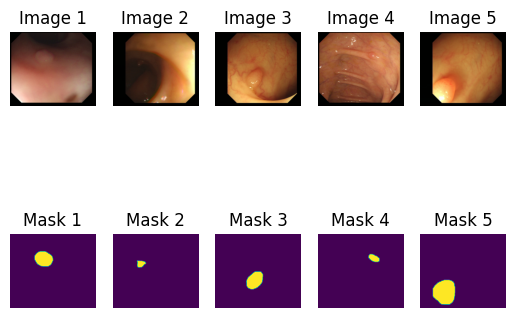

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images(image_folder, mask_folder, num_images=3):
    # Lấy danh sách tệp hình ảnh và mặt nạ
    image_files = os.listdir(image_folder)[:num_images]
    mask_files = os.listdir(mask_folder)[:num_images]

    # Hiển thị hình ảnh và mặt nạ tương ứng
    for i in range(num_images):
        # Đọc và hiển thị hình ảnh
        image_path = os.path.join(image_folder, image_files[i])
        image = mpimg.imread(image_path)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Image ' + str(i+1))

        # Đọc và hiển thị mặt nạ
        mask_path = os.path.join(mask_folder, mask_files[i])
        mask = mpimg.imread(mask_path)
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(mask)
        plt.axis('off')
        plt.title('Mask ' + str(i+1))

    plt.show()

# Đường dẫn tới thư mục chứa hình ảnh và mặt nạ
image_folder = '/kaggle/input/linknet-cvc/images'  # Thay đổi đường dẫn tương ứng
mask_folder = '/kaggle/input/linknet-cvc/masks'   # Thay đổi đường dẫn tương ứng

# Số lượng hình ảnh bạn muốn hiển thị
num_images = 5

# Hiển thị hình ảnh và mặt nạ từ tập dữ liệu
display_images(image_folder, mask_folder, num_images)


# Custom Dataset

In [8]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = os.listdir(folder_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = os.path.join(self.folder_path, self.images[idx])
        image = Image.open(image_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Load label image
        label_name = self.images[idx].split('_')[0] + '_merged.png'  # Assuming label image name follows the pattern
        label_path = os.path.join(self.folder_path, label_name)
        label = Image.open(label_path).convert('L')  # Convert to grayscale

        # Resize label to match the output size of the model
        label_resized = label.resize((256, 256), Image.NEAREST)

        # Convert label to tensor
        label_tensor = transforms.ToTensor()(label_resized)
        
        # Ensure label tensor has only one channel
        if label_tensor.ndim == 2:
            label_tensor = label_tensor.unsqueeze(0)

        return image, label_tensor.float()

# Early Stopping

In [9]:
# early stopping
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True


# Compute IOU


In [10]:
# import torch

# def compute_iou(outputs, targets, threshold=0.5):
#     # Chuyển đổi đầu ra sang dạng nhị phân dựa trên ngưỡng
#     outputs = (outputs[:, 0, :, :] > threshold).float()  # Giữ lại kênh đầu tiên
    
#     # Tính toán intersection và union
#     intersection = torch.sum(outputs * targets)
#     union = torch.sum(outputs) + torch.sum(targets) - intersection
    
#     # Tính toán IoU
#     iou = (intersection + 1e-6) / (union + 1e-6)
#     return iou.item()

# def dice_coef_metric(outputs, targets, smooth=1e-6):
#     # Chỉ lấy kênh đầu tiên của outputs
#     outputs = outputs[:, 0, :, :]
    
#     # Tính toán intersection và union
#     intersection = torch.sum(outputs * targets)
#     union = torch.sum(outputs) + torch.sum(targets)
    
#     # Tính toán Dice coefficient
#     dice = (2. * intersection + smooth) / (union + smooth)
    
#     # Giới hạn giá trị của dice trong khoảng [0, 1]
#     dice = torch.clamp(dice, 0, 1)
    
#     return dice.item()


# Hàm tính toán IoU (Intersection over Union)
def compute_iou(outputs, targets, threshold=0.5):
    # Chuyển đổi đầu ra và mục tiêu sang dạng nhị phân dựa trên ngưỡng
    outputs = (outputs > threshold).float()
    targets = (targets > 0.5).float()  # Đảm bảo targets cũng được chuyển đổi
    
    # Tính toán intersection và union
    intersection = torch.sum(outputs * targets)
    union = torch.sum(outputs) + torch.sum(targets) - intersection
    
    # Tính toán IoU
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()


# Hàm tính toán Dice coefficient
def dice_coef_metric(outputs, targets, smooth=1e-6):
    # Tính toán intersection và union
    intersection = torch.sum(outputs * targets)
    union = torch.sum(outputs) + torch.sum(targets)
    
    # Tính toán Dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)
    
    # Giới hạn giá trị của dice trong khoảng [0, 1]
    dice = torch.clamp(dice, 0, 1)
    
    return dice.item()

In [11]:
import os

def create_validation_folder(validation_folder):
    # Kiểm tra nếu thư mục validation chưa tồn tại
    if not os.path.exists(validation_folder):
        # Tạo thư mục validation
        os.makedirs(validation_folder)
        print("Thư mục validation đã được tạo.")
    else:
        print("Thư mục validation đã tồn tại.")

# Đường dẫn đến thư mục validation
validation_folder = '/kaggle/working/validation'

# Gọi hàm để tạo thư mục validation
create_validation_folder(validation_folder)

import os
import shutil
import random

def move_data_to_validation(train_folder, validation_folder, validation_ratio):
    # Lấy danh sách tất cả các tệp trong thư mục huấn luyện
    all_files = os.listdir(train_folder)
    
    # Tính toán số lượng tệp cần di chuyển dựa trên tỷ lệ phần trăm
    num_files_to_move = int(len(all_files) * validation_ratio)
    
    # Chọn ngẫu nhiên các tệp để di chuyển sang thư mục validation
    files_to_move = random.sample(all_files, num_files_to_move)
    
    # Di chuyển các tệp sang thư mục validation
    for file_name in files_to_move:
        src = os.path.join(train_folder, file_name)
        dst = os.path.join(validation_folder, file_name)
        shutil.move(src, dst)
    
    print(f"{num_files_to_move} tệp đã được di chuyển từ thư mục huấn luyện sang thư mục validation.")

# Đường dẫn đến thư mục huấn luyện và thư mục validation
train_folder = '/kaggle/working/train'
validation_folder = '/kaggle/working/validation'

# Tỉ lệ phần trăm dữ liệu bạn muốn di chuyển sang thư mục validation (ví dụ: 0.2 cho 20%)
validation_ratio = 0.2

# Gọi hàm để di chuyển dữ liệu từ thư mục huấn luyện sang thư mục validation
move_data_to_validation(train_folder, validation_folder, validation_ratio)


Thư mục validation đã được tạo.
60 tệp đã được di chuyển từ thư mục huấn luyện sang thư mục validation.


# Train model

In [12]:
# import torch
# from torch.utils.data import DataLoader
# import torch.nn as nn
# import torchvision.transforms as transforms
# import os
# import shutil
# from tqdm import tqdm

# # Chọn thiết bị để huấn luyện mô hình (GPU nếu có, nếu không sử dụng CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Hàm kiểm tra dữ liệu đầu vào
# def check_input_data(data, target):
#     print("Checking input data:")
#     print("Data shape:", data.shape)
#     print("Target shape:", target.shape)

# def train_model(model, train_loader, val_loader, optimizer, num_epochs):
#     train_losses = []
#     val_losses = []
#     train_ious = []
#     val_ious = []
#     train_dices = []
#     val_dices = []

#     criterion = nn.BCEWithLogitsLoss()  # Sử dụng hàm loss theo binary cross entropy

#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         train_iou = 0.0
#         train_dice = 0.0

#         for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)):
#             data, target = data.to(device), target.to(device)
#             optimizer.zero_grad()
#             outputs = model(data)
            
#             target = target.unsqueeze(1) 
            
#             loss = criterion(outputs, target)
#             train_loss += loss.item() * data.size(0)
            
#             # Tính toán IoU và Dice coefficient
#             iou = compute_iou(outputs, target)
#             dice = dice_coef_metric(outputs, target)
#             train_iou += iou
#             train_dice += dice
            
#             loss.backward()
#             optimizer.step()

#         train_loss /= len(train_loader.dataset)
#         train_iou /= len(train_loader)
#         train_dice /= len(train_loader)
#         train_losses.append(train_loss)
#         train_ious.append(train_iou)
#         train_dices.append(train_dice)

#         val_loss, val_iou, val_dice = evaluate_model(model, val_loader, criterion)
#         val_losses.append(val_loss)
#         val_ious.append(val_iou)
#         val_dices.append(val_dice)

#         print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Dice: {train_dice:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}")

#     return train_losses, val_losses, train_ious, val_ious, train_dices, val_dices


# def evaluate_model(model, val_loader, criterion):
#     model.eval()
#     val_loss = 0.0
#     val_iou = 0.0
#     val_dice = 0.0

#     with torch.no_grad():
#         for data, target in val_loader:
#             data, target = data.to(device), target.to(device)
#             outputs = model(data)
            
#             # Resize target to match the size of outputs
#             target = target.unsqueeze(1)  # Add a channel dimension
#             target = torch.nn.functional.interpolate(target, size=outputs.shape[2:], mode='nearest')
            
#             loss = criterion(outputs, target)
#             val_loss += loss.item() * data.size(0)
#             val_iou += compute_iou(outputs, target)
#             val_dice += dice_coef_metric(outputs, target)
    
#     val_loss /= len(val_loader.dataset)
#     val_iou /= len(val_loader)
#     val_dice /= len(val_loader)
    
#     return val_loss, val_iou, val_dice



# # Tiếp tục với việc định nghĩa các phép biến đổi cho dữ liệu
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),  # Resize ảnh về kích thước 256x256
#     transforms.ToTensor(),  # Chuyển đổi ảnh sang tensor
# ])

# # Định nghĩa đường dẫn của folder validation
# val_folder = '/kaggle/working/validation'
# train_folder = '/kaggle/working/train'

# # Tạo folder validation nếu chưa tồn tại
# create_validation_folder(val_folder)

# # Tạo đối tượng Dataset cho tập validation
# val_dataset = CustomDataset(val_folder, transform=transform)
# train_dataset = CustomDataset(train_folder, transform=transform)

# # Định nghĩa DataLoader cho tập validation
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# # Định nghĩa mô hình, tối ưu hóa và hàm mất mát
# model = LinkNet(in_channels=3, num_classes=1).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.BCEWithLogitsLoss()

# # Huấn luyện mô hình
# num_epochs = 10
# train_model(model, train_loader, val_loader, optimizer, num_epochs)


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import os
from PIL import Image
from tqdm import tqdm

# Define the CustomDataset class
# class CustomDataset(Dataset):
#     def __init__(self, data_folder, transform=None):
#         self.data_folder = data_folder
#         self.transform = transform
#         self.image_list = os.listdir(data_folder)

#     def __len__(self):
#         return len(self.image_list)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.data_folder, self.image_list[idx])
#         image = Image.open(img_name).convert('RGB')
#         if self.transform:
#             image = self.transform(image)
#         return image

# Define the generate_target function
def generate_target(data):
    batch_size, _, height, width = data.size()
    target = torch.randint(2, (batch_size, 1, height, width), dtype=torch.float32)
    return target

# Define the train_model function
# Define the train_model function
def train_model(model, train_loader, val_loader, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []
    train_dices = []
    val_dices = []

    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        train_dice = 0.0

        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            train_loss += loss.item() * data.size(0)
            iou = compute_iou(outputs, target)
            dice = dice_coef_metric(outputs, target)
            train_iou += iou
            train_dice += dice
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader.dataset)
        train_iou /= len(train_loader)
        train_dice /= len(train_loader)
        train_losses.append(train_loss)
        train_ious.append(train_iou)
        train_dices.append(train_dice)

        val_loss, val_iou, val_dice = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_dices.append(val_dice)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Dice: {train_dice:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}")

    return train_losses, val_losses, train_ious, val_ious, train_dices, val_dices

# Define other necessary functions and variables here
def evaluate_model(model, data_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_dice = 0.0

    with torch.no_grad():
        for data, target in tqdm(data_loader, desc='Validation', leave=False):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item() * data.size(0)
            iou = compute_iou(outputs, target)
            dice = dice_coef_metric(outputs, target)
            val_iou += iou
            val_dice += dice

    val_loss /= len(data_loader.dataset)
    val_iou /= len(data_loader)
    val_dice /= len(data_loader)

    return val_loss, val_iou, val_dice

# Define the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the folder paths
train_folder = '/kaggle/working/train'
validation_folder = '/kaggle/working/validation'

# Clean the data in train and validation folders
def clean_data(dataset_folder):
    # Xác định và loại bỏ các tập tin không cần thiết
    for root, dirs, files in os.walk(dataset_folder):
        for file in files:
            file_path = os.path.join(root, file)
            # Kiểm tra và loại bỏ các tập tin không phải định dạng hình ảnh
            if not file.endswith(('.jpg', '.png', '.jpeg')):
                os.remove(file_path)
                print(f"Removed: {file_path}")

clean_data(train_folder)
clean_data(validation_folder)

# Prepare DataLoader for train and validation sets
def prepare_dataloader(dataset_folder, batch_size=4, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize ảnh về kích thước 256x256
        transforms.ToTensor(),  # Chuyển đổi ảnh sang tensor
    ])

    dataset = CustomDataset(dataset_folder, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return data_loader

# Prepare DataLoader for train and validation sets
train_loader = prepare_dataloader(train_folder)
val_loader = prepare_dataloader(validation_folder)

# Define the model, optimizer, and loss function
model = LinkNet(in_channels=3, num_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
train_model(model, train_loader, val_loader, optimizer, num_epochs)


Epoch [1/10], Train Loss: 0.1047, Train IoU: 0.9685, Train Dice: 0.0095, Val Loss: 0.0413, Val IoU: 0.9939, Val Dice: 0.0000


Epoch [2/10], Train Loss: 0.0210, Train IoU: 0.9929, Train Dice: 0.0000, Val Loss: 0.0098, Val IoU: 0.9953, Val Dice: 0.0000


Epoch [3/10], Train Loss: 0.0085, Train IoU: 0.9943, Train Dice: 0.0000, Val Loss: 0.0055, Val IoU: 0.9955, Val Dice: 0.0000


Epoch [4/10], Train Loss: 0.0047, Train IoU: 0.9951, Train Dice: 0.0000, Val Loss: 0.0044, Val IoU: 0.9955, Val Dice: 0.0000


Epoch [5/10], Train Loss: 0.0034, Train IoU: 0.9952, Train Dice: 0.0000, Val Loss: 0.0030, Val IoU: 0.9959, Val Dice: 0.0000


Epoch [6/10], Train Loss: 0.0024, Train IoU: 0.9954, Train Dice: 0.0000, Val Loss: 0.0024, Val IoU: 0.9961, Val Dice: 0.0000


Epoch [7/10], Train Loss: 0.0018, Train IoU: 0.9956, Train Dice: 0.0000, Val Loss: 0.0019, Val IoU: 0.9965, Val Dice: 0.0000


Epoch [8/10], Train Loss: 0.0015, Train IoU: 0.9960, Train Dice: 0.0000, Val Loss: 0.0019, Val IoU: 0.9963, Val Dice: 0.0000


Epoch [9/10], Train Loss: 0.0013, Train IoU: 0.9960, Train Dice: 0.0000, Val Loss: 0.0013, Val IoU: 0.9962, Val Dice: 0.0000


Epoch [10/10], Train Loss: 0.0012, Train IoU: 0.9961, Train Dice: 0.0000, Val Loss: 0.0011, Val IoU: 0.9967, Val Dice: 0.0000


([0.10466059798099955,
  0.02098811965924306,
  0.008528776776015025,
  0.004692008676862374,
  0.0034306845246035544,
  0.002360399068165265,
  0.0018046686796043985,
  0.0015165447448303954,
  0.0012836017899719053,
  0.0011564649214021495],
 [0.04126671428481738,
  0.009786464522282283,
  0.005474483035504818,
  0.004401911826183398,
  0.0030498371459543707,
  0.0023923168890178205,
  0.00192250016455849,
  0.0018685485779618223,
  0.0013328988493109743,
  0.0010998610290698708],
 [0.9685086287313798,
  0.9928902631900349,
  0.9943259055497217,
  0.9951246458975995,
  0.9951697519568147,
  0.9954202360794192,
  0.9956359706941198,
  0.9959870703884812,
  0.9960248773215247,
  0.9960973165074333],
 [0.9939220190048218,
  0.9952623685201009,
  0.9954942186673482,
  0.995473857720693,
  0.9959218780199687,
  0.9961464603741964,
  0.9965163866678873,
  0.9962884982426962,
  0.9961922844250997,
  0.9967045823733012],
 [0.009511105349806488, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 

# Định nghĩa rate scheduler

In [14]:
# Define the learning rate scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

# Biểu đồ Accuracy

Epoch [1/10], Train Loss: 0.0010, Train IoU: 0.9962, Train Dice: 0.0000, Val Loss: 0.0011, Val IoU: 0.9963, Val Dice: 0.0000


Epoch [2/10], Train Loss: 0.0009, Train IoU: 0.9962, Train Dice: 0.0000, Val Loss: 0.0010, Val IoU: 0.9962, Val Dice: 0.0000


Epoch [3/10], Train Loss: 0.0008, Train IoU: 0.9963, Train Dice: 0.0000, Val Loss: 0.0009, Val IoU: 0.9968, Val Dice: 0.0000


Epoch [4/10], Train Loss: 0.0008, Train IoU: 0.9964, Train Dice: 0.0000, Val Loss: 0.0009, Val IoU: 0.9963, Val Dice: 0.0000


Epoch [5/10], Train Loss: 0.0007, Train IoU: 0.9965, Train Dice: 0.0000, Val Loss: 0.0008, Val IoU: 0.9964, Val Dice: 0.0000


Epoch [6/10], Train Loss: 0.0007, Train IoU: 0.9963, Train Dice: 0.0000, Val Loss: 0.0008, Val IoU: 0.9964, Val Dice: 0.0000


Epoch [7/10], Train Loss: 0.0007, Train IoU: 0.9963, Train Dice: 0.0000, Val Loss: 0.0007, Val IoU: 0.9965, Val Dice: 0.0000


Epoch [8/10], Train Loss: 0.0006, Train IoU: 0.9964, Train Dice: 0.0000, Val Loss: 0.0007, Val IoU: 0.9969, Val Dice: 0.0000


Epoch [9/10], Train Loss: 0.0006, Train IoU: 0.9964, Train Dice: 0.0000, Val Loss: 0.0006, Val IoU: 0.9965, Val Dice: 0.0000


Epoch [10/10], Train Loss: 0.0006, Train IoU: 0.9968, Train Dice: 0.0000, Val Loss: 0.0006, Val IoU: 0.9970, Val Dice: 0.0000


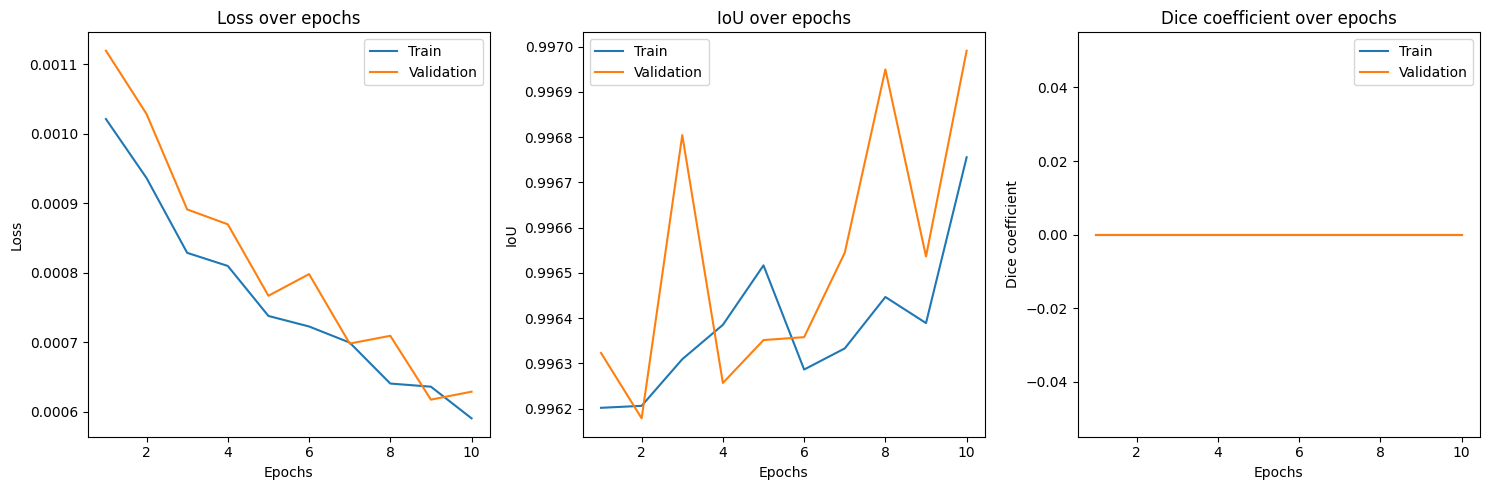

In [15]:
# # Hàm vẽ biểu đồ loss và accuracy
# def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
#     epochs = range(1, len(train_losses) + 1)

#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, train_losses, label='Train')
#     plt.plot(epochs, val_losses, label='Validation')
#     plt.title('Loss over epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, train_accuracies, label='Train')
#     plt.plot(epochs, val_accuracies, label='Validation')
#     plt.title('Accuracy over epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # Gọi hàm huấn luyện mô hình và thu thập dữ liệu
# train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# # Vẽ biểu đồ loss và accuracy sau khi đã huấn luyện xong
# plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

import matplotlib.pyplot as plt

# Hàm vẽ biểu đồ loss và accuracy
def plot_loss_accuracy(train_losses, val_losses, train_ious, val_ious, train_dices, val_dices):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))

    # Biểu đồ loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train')
    plt.plot(epochs, val_losses, label='Validation')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Biểu đồ IoU
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_ious, label='Train')
    plt.plot(epochs, val_ious, label='Validation')
    plt.title('IoU over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Biểu đồ Dice coefficient
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_dices, label='Train')
    plt.plot(epochs, val_dices, label='Validation')
    plt.title('Dice coefficient over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Dice coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Gọi hàm huấn luyện mô hình và thu thập dữ liệu
train_losses, val_losses, train_ious, val_ious, train_dices, val_dices = train_model(model, train_loader, val_loader, optimizer, num_epochs)

# Vẽ biểu đồ loss và accuracy sau khi đã huấn luyện xong
plot_loss_accuracy(train_losses, val_losses, train_ious, val_ious, train_dices, val_dices)
